---
title: "Capa de Transporte"
subtitle: "Comunicación lógica entre procesos de aplicación"
author: "Rubén Rodríguez Fernández (@rrunix)"
date: "23/09/2025"

mermaid:
      theme: default
---

# Introducción

## ¿Qué es la Capa de Transporte?

::: {.columns}
::: {.column width="50%"}
**Función principal:**

Proporciona comunicación lógica entre procesos de aplicación que se ejecutan en diferentes hosts

- Se ejecuta en hosts finales
- No en el núcleo de la red
- Divide mensajes en segmentos
- Recompone segmentos en el receptor
:::

::: {.column width="50%"}
**Protocolos principales:**

- **UDP**: Protocolo minimalista
- **TCP**: Protocolo complejo con garantías

La elección depende del dominio y la aplicación
:::
:::

## Ejemplo: Cliente-Servidor con UDP

::: {style="width: 50vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
%%| fig-align: center
sequenceDiagram
    participant A as Client A
    participant I as The Internet
    participant B as Server B
        
    A->>I: Paquete UDP 1 (IP destino: 8.8.8.8, puerto: 80)
    I->>B: Paquete 1 entregado
    
    A->>I: Paquete UDP 2 (IP destino: 8.8.8.8, puerto:80)
    I->>B: Paquete 2 entregado
    
    A->>I: Paquete UDP 3 (IP destino: 8.8.8.8, puerto:80)
    
    A->>I: Paquete UDP 4 (IP destino: 8.8.8.8, puerto:80)
    I->>B: Paquete 4 entregado (llega primero!)
    A->>I: Paquete UDP 5 (IP destino: 8.8.8.8, puerto:80)
    I->>B: Paquete 3 entregado (llega tarde!)
```
:::


- Paquete 5: perdido (~1% pérdida normal)
- Paquete 4 llega antes que el 3
- UDP no corrige orden ni pérdidas


# Funciones Principales

## 1. Multiplexación y Demultiplexación

**Multiplexación:** Recoger información de diferentes sockets y enviarla por un único medio.

**Demultiplexación:** Recibir segmentos y enviarlos a los sockets correspondientes.

::: {.columns}
::: {.column width="50%"}
**Identificación de sockets:**

- TCP: (IP y Puerto origen, IP y puerto destino)
- UDP: ([IP y puerto origen]{style="color:red;"}, IP y puerto destino)
:::
::: {.column width="50%"}
**Puertos:** Identificadores numéricos (1-65535)

- Servidores: asignación manual y fija
- Clientes: asignación aleatoria
:::
:::

```{mermaid}
graph LR
    subgraph "MULTIPLEXACIÓN"
        A1[Socket 1<br/>App A] --> M[Multiplexor<br/>Capa de Transporte]
        A2[Socket 2<br/>App B] --> M
        A3[Socket 3<br/>App C] --> M
        M --> N[Red<br/>Medio único]
    end
    
    subgraph "DEMULTIPLEXACIÓN"
        N2[Red<br/>Segmentos entrantes] --> D[Demultiplexor<br/>Capa de Transporte]
        D --> B1[Socket 1<br/>App A]
        D --> B2[Socket 2<br/>App B]
        D --> B3[Socket 3<br/>App C]
    end
    
    N -.->|Transmisión| N2
    
    classDef appClass fill:#e1f5fe,stroke:#0277bd,stroke-width:2px
    classDef muxClass fill:#f3e5f5,stroke:#7b1fa2,stroke-width:2px
    classDef netClass fill:#fff3e0,stroke:#f57c00,stroke-width:2px
    
    class A1,A2,A3,B1,B2,B3 appClass
    class M,D muxClass
    class N,N2 netClass
```



## 2. Transferencia Fiable


::: {.columns}
::: {.column width="50%"}
**Características de una transferencia fiable:**


- No se corrompe ningún bit
- No se pierde información (paquetes)
- La información se entrega en orden correcto
:::
::: {.column width="50%"}

**Opciones de implementación:**

1. Usar protocolos fiables existentes (TCP)
2. Implementar características propias sobre protocolo no fiable (UDP + lógica aplicación)
:::
:::


```{mermaid}
graph LR
    
    E[EMISOR] --> PC1[PROTOCOLO<br/>CONFIABILIDAD]
    PC1 --> MNF[MEDIO<br/>NO FIABLE<br/><br/>• Puede corromper bits<br/>• Puede perder paquetes<br/>• Puede desordenar]
    MNF --> PC2[PROTOCOLO<br/>CONFIABILIDAD]
    PC2 --> R[RECEPTOR]
    
    PC1 -.->|Implementa| MECH[• Detección de errores<br/>• Retransmisión<br/>• Control de flujo<br/>• Secuenciación<br/>• ACK/NACK<br/>• Timeouts]
    PC2 -.->|Implementa| MECH
    
    classDef endpointClass fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    classDef protocolClass fill:#e8f5e8,stroke:#2e7d32,stroke-width:2px
    classDef unreliableClass fill:#ffebee,stroke:#d32f2f,stroke-width:2px
    classDef reliableClass fill:#f3e5f5,stroke:#7b1fa2,stroke-width:2px
    classDef mechClass fill:#fafafa,stroke:#616161,stroke-width:1px
    
    class E,R endpointClass
    class PC1,PC2 protocolClass
    class MNF unreliableClass
    class MECH mechClass
```

# UDP (User Datagram Protocol)

## Características de UDP

::: {.columns}
::: {.column width="50%"}
**Protocolo minimalista [RFC 768]:**

- Basado en best-effort
- No orientado a conexión
- Entrega no fiable y sin orden
- Integridad básica (checksum)
- Multiplexación y demultiplexación
:::

::: {.column width="50%"}
**Lo que NO proporciona:**

- Control de flujo
- Control de congestión
- Temporización
- Tasa de transferencia mínima
- Seguridad
:::
:::

::: {.fragment}
**"Fire-and-forget":** Envías el paquete y te olvidas, independientemente de si llega
:::

## Estructura del Paquete UDP

```{mermaid}
%%| fig-height: 6
%%| fig-align: center
%%| out-width: "80%"
packet-beta

    0-15: "Source Port"
    16-31: "Destination Port"
    32-47: "Length"
    48-63: "Checksum"
```

- **Longitud:** Hasta 65535 bytes (limitado por MTU)
- **Checksum:** Verificación de integridad
- Estructura simple comparada con otros protocolos


## Checksum UDP

**Proceso de cálculo:**

1. Preparación: pseudo-cabecera IP + cabecera UDP + datos
2. División en palabras de 16 bits
3. Suma usando aritmética de complemento a uno
4. Complemento del resultado → campo checksum


**Verificación en receptor:**

- Mismo algoritmo incluyendo checksum recibido
- Resultado esperado: 0xFFFF
- Si difiere: datagrama descartado silenciosamente


## Casos de Uso de UDP

**Aplicaciones ideales para UDP:**

- **Multimedia streaming:** Tolerante a pérdidas, sensible a interrupciones
- **DNS:** Respuestas rápidas necesarias
- **SNMP:** Administración de red
- **Gaming online:** Latencia baja crítica
- **QUIC/HTTP3:** Base para protocolos modernos optimizados

Ejemplo: Implementar protocolo propio sobre UDP para juegos

- Añadir número de paquete
- Descartar paquetes fuera de orden
- Ignorar duplicados
- Sobrecarga mínima

# TCP (Transmission Control Protocol)

## Características de TCP

::: {.columns}
::: {.column width="50%"}
**Protocolo confiable [RFC 793]:**

- Orientado a conexión
- Entrega fiable y ordenada
- Control de flujo
- Control de congestión
- Multiplexación y demultiplexación
:::

::: {.column width="50%"}
**Lo que NO proporciona:**

- Temporización específica
- Tasa mínima garantizada
- Seguridad nativa (necesita TLS/SSL)
:::
:::


**Trade-off:** Confiabilidad y orden sobre velocidad pura


## Estructura del Paquete TCP

::: {style="width: 50vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 6
%%| fig-align: center
%%| out-width: "80%"
packet-beta
  0-15: "Source Port"
  16-31: "Destination Port"
  32-63: "Sequence Number"
  64-95: "Acknowledgment Number"
  96-99: "Data Offset"
  100-105: "Reserved"
  106: "URG"
  107: "ACK"
  108: "PSH"
  109: "RST"
  110: "SYN"
  111: "FIN"
  112-127: "Window"
  128-143: "Checksum"
  144-159: "Urgent Pointer"
  160-191: "Options (variable)"
```
:::
- **Sequence number**: Número que identifica la posición del primer byte de datos en el segmento dentro del flujo de datos.
- **Ack number**: Indica el próximo número de secuencia que el receptor espera recibir. Confirma la recepción correcta de datos anteriores.
- **Window:** Implementa control de flujo (bytes que receptor acepta)

## Handshake de Tres Fases

::: {style="width: 38vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
%%| fig-align: center
sequenceDiagram
    participant CS as Cliente Socket
    participant SS as Server Socket (listen)
    participant NS as Nuevo Socket
    
    Note over CS: Estado: CLOSED
    Note over SS: Estado: LISTEN
    CS->>SS: SYN=1, seq=x
    Note over CS: Estado: SYN_SENT
    Note over SS: accept() crea nuevo socket
    SS->>NS: Deriva conexión
    Note over NS: Estado: SYN_RCVD
    NS->>CS: SYN=1, ACK=1, seq=y, ack=x+1
    Note over CS: Estado: ESTABLISHED
    CS->>NS: ACK=1, seq=x+1, ack=y+1
```
:::

- Se negocian: MSS, opciones de ventana, extensiones TCP
- Los flags de las cabeceras también consumen bits.


## Mecanismos de Confiabilidad

**Números de secuencia y ACKs:**

- Cada byte tiene número único
- ACKs acumulativos (ACK para byte N confirma hasta N-1)


**Detección de pérdidas - Dos métodos:**

- Detección de timeout
- Detección de ACKs duplicados


## Detección por Timeout

```{mermaid}
%%| fig-width: 6
%%| fig-height: 4
sequenceDiagram
    participant E as Emisor
    participant R as Receptor
    E ->> X: seq=100, data="A", Paquete perdido
    Note over E: Timeout de seq:100, reenvio
    E ->> R: seq=100, data="A",
```


Si no recibe ACK en tiempo determinado → asume pérdida y retransmite


## Detección por ACKs Duplicados

::: {style="width: 38vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-width: 6
%%| fig-height: 4
sequenceDiagram
    participant E as Emisor
    participant R as Receptor
    E ->> X: seq=100, data="A", Paquete perdido
    E ->> R: seq=101, data="B"
    E ->> R: seq=102, data="C"
    E ->> R: seq=103, data="D"
    R ->> E: ACK=100
    R ->> E: ACK=100
    R ->> E: ACK=100
    Note over E,R: Retransmisión rápida
    E ->> R: seq=100, data="A"
```
:::

3 ACKs duplicados → Fast Retransmit inmediato


## Control de Flujo

::: {style="width: 38vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
%%| fig-align: center
sequenceDiagram
    participant E as Emisor
    participant R as Receptor
    
    Note over R: Buffer: 4KB libres
    R->>E: ACK=1000, Window=4096
    E->>R: seq=1000, data=2KB
    Note over R: Buffer: 2KB libres
    R->>E: ACK=3000, Window=2048
    E->>R: seq=3000, data=2KB
    Note over R: Buffer: 0KB libres (lleno)
    R->>E: ACK=5000, Window=0
    Note over E: Detiene envío, inicia probe timer
```
:::

```
VentanaRecepcion = BufferRecepcion - (UltimoByteRecibido - UltimoByteLeido)
```

## Control de Congestión

**Ventana de congestión:**

- Variable del emisor
- Bytes máximos en "el aire" (enviados sin ACK)
- Tasa efectiva = min(VentanaCongestion, VentanaRecepcion)

## Slow Start

::: {style="width: 38vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
sequenceDiagram
    participant E as Emisor
    participant R as Receptor
    
    Note over E: Slow Start: cwnd=1 MSS
    E->>R: seq=1000, MSS=1KB
    R->>E: ACK=2000
    Note over E: cwnd=2 MSS
    E->>R: seq=2000, MSS=1KB
    E->>R: seq=3000, MSS=1KB
    R->>E: ACK=3000
    R->>E: ACK=4000
    Note over E: cwnd=4 MSS (crecimiento exponencial)
    Note over E: ... continúa hasta threshold o detectar pérdida ...
```
:::

## Congestion Avoidance  

::: {style="width: 36vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
sequenceDiagram
    participant E as Emisor
    participant R as Receptor
    
    Note over E: Congestion Avoidance: cwnd=1 MSS

    E->>R: seq=1000, MSS=1KB
    R->>E: ACK=2000

    Note over E: cwnd=2 MSS

    E->>R: seq=2000, MSS=1KB
    E->>R: seq=3000, MSS=1KB
    R->>E: ACK=3000
    R->>E: ACK=4000

    Note over E: cwnd=3 MSS (crecimiento lineal)
    Note over E: ... continúa hasta detectar pérdida ...
```
:::

## Eventos de Congestión

**Respuesta a pérdidas:**

- **Timeout:** 

  - Pérdida severa
  - Ventana → 1 MSS
  - Modo slow start

- **3 ACKs duplicados:**

  - Pérdida moderada
  - Ventana → mitad
  - Continúa congestion avoidance

Crea patrón "diente de sierra" en throughput

## Ejemplo de patrón de sierra
::: {style="width: 40vw; text-align: center; margin: 0 auto;"}

/var/folders/r7/0r777bg56354s61h6g7c7vyc0000gn/T/ipykernel_31881/2809004911.py:90: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "rv" (-> color='r'). The keyword argument will take precedence.



<Figure size 1344x768 with 0 Axes>

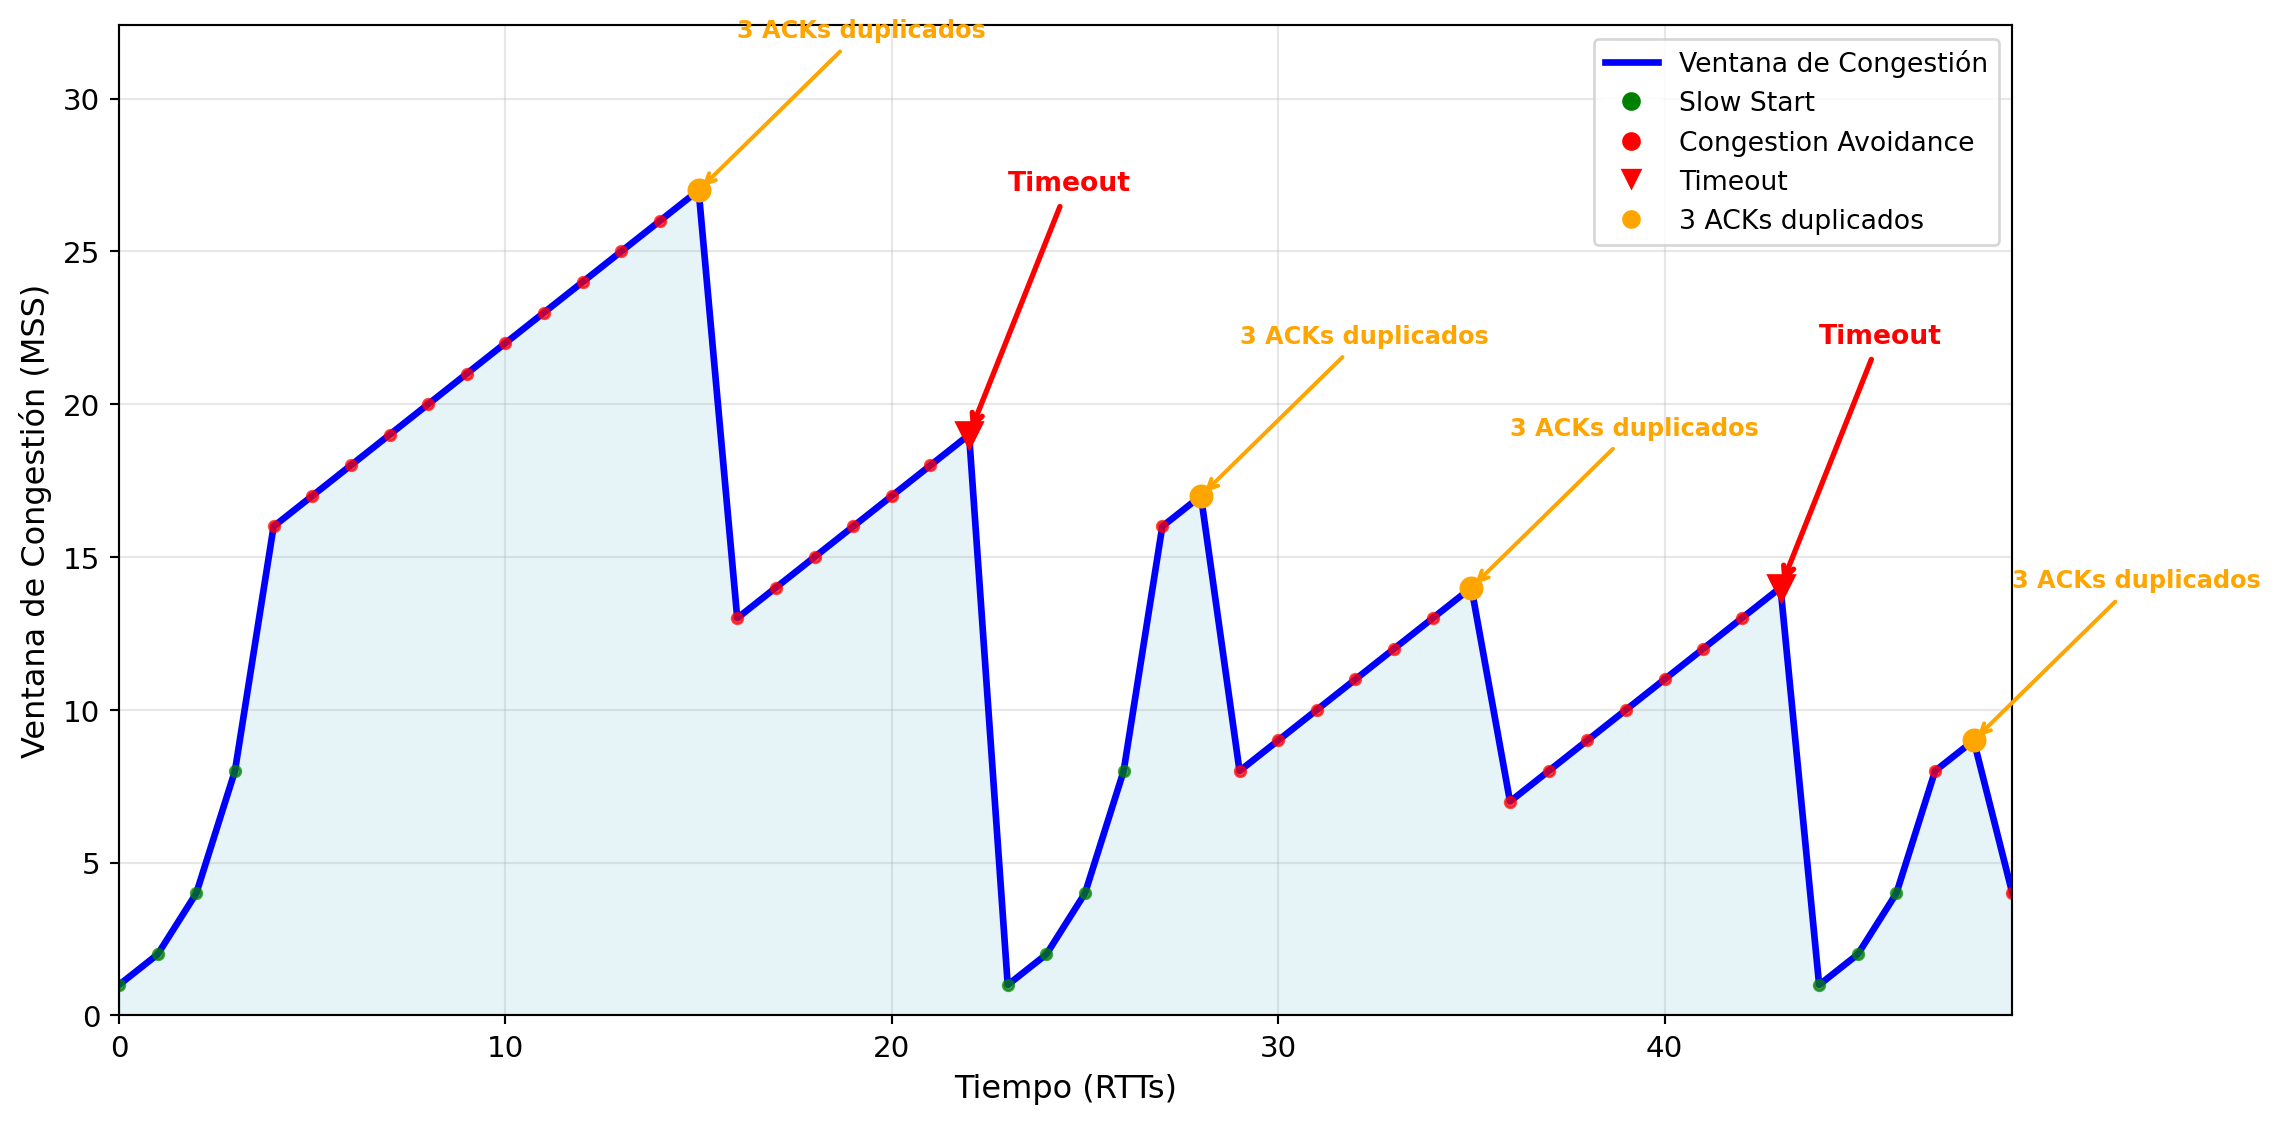

In [1]:
#| echo: false
#| warning: false

import matplotlib.pyplot as plt
import numpy as np

# Configurar el gráfico
plt.figure(figsize=(14, 8))
plt.rcParams['font.size'] = 11

# Parámetros de simulación
rtt_count = 50
ventana = []
tiempo = []
fases = []
eventos = []

# Estado inicial
ventana_actual = 1  # MSS
umbral = 16  # Slow Start Threshold
tiempo_actual = 0
fase_actual = "Slow Start"

# Simulación del comportamiento TCP
for rtt in range(rtt_count):
    ventana.append(ventana_actual)
    tiempo.append(tiempo_actual)
    fases.append(fase_actual)
    
    # Simular eventos de pérdida en momentos específicos
    perdida = False
    tipo_perdida = None
    
    # Pérdida por timeout (más severa) - ocurre menos frecuentemente
    if rtt in [22, 43]:
        perdida = True
        tipo_perdida = "timeout"
        eventos.append((tiempo_actual, ventana_actual, "Timeout"))
        
    # Pérdida por 3 ACKs duplicados - ocurre más frecuentemente
    elif rtt in [15, 28, 35, 48]:
        perdida = True
        tipo_perdida = "3_acks"
        eventos.append((tiempo_actual, ventana_actual, "3 ACKs duplicados"))
    
    # Lógica de control de congestión
    if perdida:
        if tipo_perdida == "timeout":
            # Timeout: reiniciar a 1 MSS y ajustar umbral
            umbral = max(ventana_actual // 2, 2)
            ventana_actual = 1
            fase_actual = "Slow Start"
        elif tipo_perdida == "3_acks":
            # Fast recovery: reducir a la mitad
            umbral = max(ventana_actual // 2, 2)
            ventana_actual = umbral
            fase_actual = "Congestion Avoidance"
    else:
        # Crecimiento normal
        if fase_actual == "Slow Start":
            # Crecimiento exponencial
            ventana_actual = min(ventana_actual * 2, 64)  # Limitar crecimiento
            # Cambiar a Congestion Avoidance si alcanza el umbral
            if ventana_actual >= umbral:
                fase_actual = "Congestion Avoidance"
        elif fase_actual == "Congestion Avoidance":
            # Crecimiento lineal (+1 MSS por RTT)
            ventana_actual += 1
    
    tiempo_actual += 1

# Crear el gráfico principal
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de ventana de congestión
line, = ax1.plot(tiempo, ventana, 'b-', linewidth=2.5, label='Ventana de Congestión')
ax1.fill_between(tiempo, ventana, alpha=0.3, color='lightblue')

# Colorear diferentes fases
for i in range(len(tiempo)):
    if fases[i] == "Slow Start":
        ax1.plot(tiempo[i], ventana[i], 'go', markersize=4, alpha=0.7)
    else:
        ax1.plot(tiempo[i], ventana[i], 'ro', markersize=4, alpha=0.7)

# Marcar eventos de pérdida
for evento in eventos:
    t, v, tipo = evento
    if "Timeout" in tipo:
        ax1.annotate(f'{tipo}', xy=(t, v), xytext=(t+1, v+8),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, ha='left', color='red', weight='bold')
        ax1.plot(t, v, 'rv', markersize=10, color='red')
    else:
        ax1.annotate(f'{tipo}', xy=(t, v), xytext=(t+1, v+5),
                    arrowprops=dict(arrowstyle='->', color='orange', lw=1.5),
                    fontsize=9, ha='left', color='orange', weight='bold')
        ax1.plot(t, v, 'o', markersize=8, color='orange')

# Configurar el gráfico principal
ax1.set_xlabel('Tiempo (RTTs)', fontsize=12)
ax1.set_ylabel('Ventana de Congestión (MSS)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(tiempo))
ax1.set_ylim(0, max(ventana) * 1.2)

# Leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2.5, label='Ventana de Congestión'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8, label='Slow Start'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8, label='Congestion Avoidance'),
    Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Timeout'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='3 ACKs duplicados')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
_ = plt.show()

:::

## Terminación de Conexión

::: {style="width: 28vw; text-align: center; margin: 0 auto;"}
```{mermaid}
%%| fig-height: 4
sequenceDiagram
    participant C as Cliente
    participant S as Servidor
    
    Note over C,S: Conexión establecida
    C->>S: FIN=1, seq=x
    Note over C: Estado: FIN_WAIT_1
    S->>C: ACK=1, ack=x+1
    Note over C: Estado: FIN_WAIT_2
    S->>C: FIN=1, ACK=1, seq=y
    Note over S: Estado: LAST_ACK
    C->>S: ACK=1, ack=y+1
    Note over C: Estado: TIME_WAIT
    Note over C: Espera 2*MSL
    Note over C,S: CLOSED
```
:::

## Equidad y Coexistencia

**TCP es "fair":**

- N conexiones TCP comparten enlace equitativamente
- Cada una obtiene ~R/N del ancho de banda R

::: {.fragment}
**Limitaciones:**

- UDP no implementa control → puede monopolizar
- Aplicaciones con múltiples conexiones TCP
- Conexiones con menor RTT tienen ventaja
:::

# Comparativa TCP vs UDP para Videojuegos

## Cuándo usar UDP

**Requisitos para UDP:**

- Latencias < 50ms
- Actualizaciones frecuentes
- Información nueva más valiosa que la vieja


**Ventajas:**

- Cabeceras pequeñas
- Sin tráfico de control
- Servidor necesita menos recursos
- No mantiene estado

**Ejemplos:** Shooters (Counter Strike), juegos de lucha

## Cuándo usar TCP

**Requisitos para TCP:**
- Tolerancia 100-200ms latencia
- Entrega ordenada garantizada
- Detección y corrección de errores

**Consideraciones:**
- Bloqueo cabeza de línea
- Latencias variables por retransmisiones
- Mayor tráfico de red

**Ejemplos:** MMORPGs (World of Warcraft), juegos por turnos

## Ejemplos Concretos

::: {.columns}
::: {.column width="50%"}
**World of Warcraft (TCP):**

- Hechizos necesitan entrega garantizada
- Actualizaciones de inventario críticas
- Estado de misiones consistente
- MMORPGs toleran 100-200ms
:::

::: {.column width="50%"}
**Counter Strike (UDP):**

- Retroalimentación inmediata crítica
- Actualizaciones posición/disparos
- Técnicas de interpolación en cliente
- Mitiga efecto paquetes perdidos
:::
:::

# Resumen

## Puntos Clave

::: {.incremental}
- La capa de transporte proporciona comunicación lógica entre **procesos**
- **UDP:** Minimalista, best-effort, no orientado a conexión
- **TCP:** Confiable, ordenado, orientado a conexión
- **Multiplexación:** Múltiples sockets por un medio
- **Control de flujo:** Evita saturar al receptor
- **Control de congestión:** Responde a condiciones de red
- **Trade-off fundamental:** Confiabilidad vs velocidad
- Elección protocolo depende de requisitos aplicación
:::